## Plan to focus on Carbon Utilization [TODO] {TODO} 
- [x] M011
- [x] M012
- [x] G7945 
- [x] G7445

In [1]:
import numpy as np
import ast
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import cvxpy as cp
import itertools
import networkx as nx
import plotly.express as px

from scipy.special import logsumexp

%matplotlib inline
# sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/dev/vivarium-ecoli'))

from ecoli.processes.metabolism_redux_classic import NetworkFlowModel, FlowResult
from ecoli.library.schema import numpy_schema, bulk_name_to_idx, listener_schema, counts
from ecoli.processes.registries import topology_registry
TOPOLOGY = topology_registry.access("ecoli-metabolism-redux")

In [2]:
# load basal new model
time = '400'
date = '2025-01-30'
experiment = 'NEW_updated_bad_rxn'
condition = 'basal'
entry = f'{experiment}_{time}_{date}'
folder = f'out/metabolism-comparison/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba_basal = output['listeners']['fba_results']
bulk = pd.DataFrame(output['bulk'])
f = open(folder + 'agent_steps.pkl', 'rb')
agent_basal = dill.load(f)
f.close()

In [3]:
# get commonly stored variables
metabolism_basal = agent_basal['ecoli-metabolism-redux-classic']
stoichiometry = metabolism_basal.stoichiometry.copy()
reaction_names = metabolism_basal.reaction_names
kinetic_reaction_ids = metabolism_basal.kinetic_constraint_reactions
fba_new_reaction_ids = metabolism_basal.parameters["fba_new_reaction_ids"]
fba_reaction_ids_to_base_reaction_ids = metabolism_basal.parameters['fba_reaction_ids_to_base_reaction_ids']
binary_kinetic_idx = metabolism_basal.binary_kinetic_idx
metabolites = metabolism_basal.metabolite_names

S = stoichiometry.copy()
S = pd.DataFrame(S, index=metabolites, columns=reaction_names)
homeostatic_count = pd.DataFrame(fba_basal["homeostatic_metabolite_counts"], columns=metabolism_basal.homeostatic_metabolites).loc[24, :]
homeostatic = pd.DataFrame(fba_basal["target_homeostatic_dmdt"], columns=metabolism_basal.homeostatic_metabolites).loc[24, :]
maintenance = pd.DataFrame(fba_basal["maintenance_target"][1:], columns=['maintenance_reaction']).iat[24, 0]

FREE_RXNS = ["TRANS-RXN-145", "TRANS-RXN0-545", "TRANS-RXN0-474"]

## load variables from track_reaction_usage.ipynb

In [4]:
%store -r df_reaction_flux df_reaction_track df_gene_usage unused_kinetic_gene

In [5]:
genes_of_interest = ['EG11685','EG10456','G6286','EG11017','EG10033','EG10369']
unused_kinetic_gene.loc[genes_of_interest]

# not all reactions in the unused_kinetic_genes are included in the model
# here, I am manually extracting rxns of the genes of interest
rxns_of_interest = ['RXN-12402', 'RXN-12402-CPD0-1202/WATER//ALPHA-GLUCOSE/CPD-25028.41.', 'RXN-12402-CPD0-1202/WATER//GLC/CPD-25028.31.',
                    'R621-RXN-NITRIC-OXIDE/NADH/OXYGEN-MOLECULE//NITRATE/NAD/PROTON.54.',
                    'R621-RXN-NITRIC-OXIDE/NADPH/OXYGEN-MOLECULE//NITRATE/NADP/PROTON.56.',
                    'RXN0-7024', 'TREHALA-RXN[CCO-PERI-BAC]-TREHALOSE/WATER//GLC/ALPHA-GLUCOSE.49.',
                    'GLUCOSE-1-PHOSPHAT-RXN[CCO-PERI-BAC]-GLC-1-P/WATER//ALPHA-GLUCOSE/Pi.46.',
                    'GLUCOSE-1-PHOSPHAT-RXN[CCO-PERI-BAC]-GLC-1-P/WATER//GLC/Pi.36.',
                    'GLUCOSE-1-PHOSPHAT-RXN[CCO-PERI-BAC]-GLC-1-P/WATER//Glucopyranose/Pi.46.', 'RXN0-1001',
                    'RXN0-6373-ALPHA-GLUCOSE/UBIQUINONE-8//GLC-D-LACTONE/CPD-9956.51.',
                    'RXN0-6373-GLC/UBIQUINONE-8//GLC-D-LACTONE/CPD-9956.41.',
                    'RXN0-6373-Glucopyranose/UBIQUINONE-8//GLC-D-LACTONE/CPD-9956.51.',
                    ]
df_reaction_flux.loc[rxns_of_interest]

,basal,acetate,rich,anaerobic_basal,anaerobic_acetate,anaerobic_rich,is_new,is_kinetic
RXN-12402,0.0,0.0,0.0,-0.0,-0.0,False,True,True
RXN-12402-CPD0-1202/WATER//ALPHA-GLUCOSE/CPD-25028.41.,0.0,0.0,0.0,-0.0,-0.0,False,True,False
RXN-12402-CPD0-1202/WATER//GLC/CPD-25028.31.,0.0,0.0,0.0,-0.0,-0.0,False,True,False
R621-RXN-NITRIC-OXIDE/NADH/OXYGEN-MOLECULE//NITRATE/NAD/PROTON.54.,0.0,0.0,0.0,-0.0,-0.0,False,True,True
R621-RXN-NITRIC-OXIDE/NADPH/OXYGEN-MOLECULE//NITRATE/NADP/PROTON.56.,0.0,0.0,0.0,-0.0,-0.0,False,True,False
RXN0-7024,0.0,0.0,0.0,-0.0,-0.0,False,True,True
TREHALA-RXN[CCO-PERI-BAC]-TREHALOSE/WATER//GLC/ALPHA-GLUCOSE.49.,0.0,0.0,0.0,0.0,0.0,False,True,True
GLUCOSE-1-PHOSPHAT-RXN[CCO-PERI-BAC]-GLC-1-P/WATER//ALPHA-GLUCOSE/Pi.46.,0.0,0.0,0.0,-0.0,-0.0,False,True,False
GLUCOSE-1-PHOSPHAT-RXN[CCO-PERI-BAC]-GLC-1-P/WATER//GLC/Pi.36.,0.0,0.0,0.0,-0.0,-0.0,False,True,False
GLUCOSE-1-PHOSPHAT-RXN[CCO-PERI-BAC]-GLC-1-P/WATER//Glucopyranose/Pi.46.,0.0,0.0,0.0,-0.0,-0.0,False,True,False


## Define functions for testing

In [56]:
def get_subset_S(S, met_of_interest):
    S_met = S.loc[met_of_interest, :]
    S_met = S_met.loc[:,~np.all(S_met == 0, axis=0)]
    return S_met, S_met.columns

def test_NetworkFlowModel(objective_weights,
                          uptake_addition = set([]), uptake_removal = set([]), new_exchange_molecules = set([]),
                          add_metabolite = None, add_reaction = None, add_kinetic = None, remove_reaction = None, force_reaction = None):
    # update exchanges
    uptake = metabolism_basal.allowed_exchange_uptake.copy()
    uptake = set(uptake)
    uptake = uptake | uptake_addition
    uptake = uptake - uptake_removal
    
    exchange_molecules = metabolism_basal.exchange_molecules.copy()
    exchange_molecules = exchange_molecules | new_exchange_molecules
    
    # update stoichiometry
    reaction_names = metabolism_basal.reaction_names.copy()
    kinetic_reaction_ids = metabolism_basal.kinetic_constraint_reactions.copy()
    kinetic = pd.DataFrame(fba_basal["target_kinetic_fluxes"], columns=metabolism_basal.kinetic_constraint_reactions).loc[24, :].copy()
    metabolites = metabolism_basal.metabolite_names.copy()
    
    S_new = stoichiometry.copy()
    
    if add_metabolite is not None: # add to metabolites list because they are currently not included in the model
        for m in add_metabolite:
            if m not in metabolites:
                metabolites.append(m)
        # append rows of zeros to S_new of length add_metabolite
        S_new = np.concatenate((S_new, np.zeros((len(add_metabolite), S_new.shape[1]))), axis=0)
        print(S_new.shape)
    
    if add_reaction is not None:
        # assert add_reaction is a dictionary
        assert isinstance(add_reaction, dict)
        
        for r,s in add_reaction.items():
            if r not in reaction_names:
                reaction_names.append(r)
            # append columns of reaction stoich to S_new of length add_reaction
            new_reaction = np.zeros((S_new.shape[0], 1))
            for m, v in s.items():
                new_reaction[metabolites.index(m), 0] = v
            S_new = np.concatenate((S_new, new_reaction), axis=1)
        print(S_new.shape)
    
    if add_kinetic is not None:
        # assert add_kinetic is a dictionary
        assert isinstance(add_kinetic, dict)
        
        for r, v in add_kinetic.items():
            if r not in kinetic_reaction_ids:
                kinetic_reaction_ids.append(r)
                kinetic[r] = v
                
    if remove_reaction is not None:
        for r in remove_reaction:
            r_idx = reaction_names.index(r)
            S_new = np.delete(S_new, r_idx, axis=1)
            reaction_names.remove(r)
            if r in kinetic_reaction_ids:
                kinetic_reaction_ids.remove(r)
                del kinetic[r]
                
    if force_reaction is not None:
        force_reaction_idx = np.array([reaction_names.index(r) for r in force_reaction])
    else:
        force_reaction_idx = force_reaction

    print(f'Force Reaction ID is:',force_reaction_idx)
    # Solve NetworkFlowModel
    model = NetworkFlowModel(
            stoich_arr=S_new,
            metabolites=metabolites,
            reactions=reaction_names,
            homeostatic_metabolites=metabolism_basal.homeostatic_metabolites,
            kinetic_reactions=kinetic_reaction_ids,
            free_reactions=FREE_RXNS)
    model.set_up_exchanges(exchanges=exchange_molecules, uptakes=uptake)
    solution: FlowResult = model.solve(
            homeostatic_concs=homeostatic_count * metabolism_basal.counts_to_molar.asNumber(), # in conc
            homeostatic_dm_targets=np.array(list(dict(homeostatic).values())), # *10^7
            maintenance_target=maintenance, # *10^6 ish
            kinetic_targets=np.array(list(dict(kinetic).values())), # *10^6 ish
            # binary_kinetic_idx=binary_kinetic_idx, #7646
            binary_kinetic_idx=None,
            force_flow_idx=force_reaction_idx,
            objective_weights=objective_weights, #same
            upper_flux_bound= 1000000000, # increase to 10^9 because notebook runs FlowResult using Counts, WC runs using conc.   
            solver=cp.GLOP) #SCS. ECOS
    print(f'Optimal objective function reached is: {solution.objective}')
    return solution.velocities, reaction_names, S_new, metabolites, kinetic

## M011 and M012

In [7]:
# print M011 reaction stoichiometry
M011_S = S.loc[:, ['RXN-12073','1.13.11.16-RXN']]
M011_S = M011_S.loc[~np.all(M011_S == 0, axis=1), :]
print(M011_S.index)
met_of_interest = ['2-3-DIHYDROXYPHENYL-PROPIONATE[c]', 'CPD-10796[c]', 'CPD-157[c]','CPD0-2184[c]']
M011_S, rxns_of_interest = get_subset_S(S, met_of_interest)
M011_S = M011_S.loc[:, ~np.all(M011_S == 0, axis=0)]
M011_S

Index(['2-3-DIHYDROXYPHENYL-PROPIONATE[c]', 'CPD-10796[c]', 'CPD-157[c]',
       'CPD0-2184[c]', 'OXYGEN-MOLECULE[c]', 'PROTON[c]'],
      dtype='object')


,1.13.11.16-RXN,MHPCHYDROL-RXN,MHPHYDROXY-RXN,PHENPRODIOLDEHYDROG-RXN,RXN-10040,RXN-12070,RXN-12071,RXN-12073
2-3-DIHYDROXYPHENYL-PROPIONATE[c],-1,0,1,1,0,0,0,0
CPD-10796[c],0,0,0,0,1,0,1,-1
CPD-157[c],1,-1,0,0,0,0,0,0
CPD0-2184[c],0,0,0,0,0,-1,0,1


In [83]:
df_reaction_flux.loc[rxns_of_interest,:]

,basal,acetate,rich,anaerobic_basal,anaerobic_acetate,anaerobic_rich,is_new,is_kinetic
1.13.11.16-RXN,0.0,0.0,0.0,0.0,0.0,False,True,True
MHPCHYDROL-RXN,0.0,0.0,0.0,0.0,0.0,False,True,True
MHPHYDROXY-RXN,0.0,0.0,0.0,0.0,0.0,False,True,False
PHENPRODIOLDEHYDROG-RXN,0.0,0.0,0.0,0.0,0.0,False,True,False
RXN-10040,0.0,0.0,0.0,-0.0,-0.0,False,True,False
RXN-12070,0.0,0.0,0.0,-0.0,-0.0,False,True,True
RXN-12071,0.0,0.0,0.0,-0.0,-0.0,False,True,False
RXN-12073,0.0,0.0,0.0,-0.0,-0.0,False,True,False


MHPCHYDROL-RXN and RXN-12070 are catalyzed by Gene M012. So we can look at the genes together

### search upstream of 2-3-HYDROXYPHENYL-PROPIONATE[c]

In [84]:
S_temp = S.loc[:, ['MHPHYDROXY-RXN','PHENPRODIOLDEHYDROG-RXN']]
S_temp = S_temp.loc[~np.all(S_temp == 0, axis=1), :]
S_temp

,MHPHYDROXY-RXN,PHENPRODIOLDEHYDROG-RXN
2-3-DIHYDROXYPHENYL-PROPIONATE[c],1,1
3-HYDROXYPHENYL-PROPIONATE[c],-1,0
CARBOXYETHYL-3-5-CYCLOHEXADIENE-1-2-DIOL[c],0,-1
NADH[c],-1,1
NAD[c],1,-1
OXYGEN-MOLECULE[c],-1,0
PROTON[c],-1,1
WATER[c],1,0


In [85]:
met_of_interest = ['3-HYDROXYPHENYL-PROPIONATE[c]','CARBOXYETHYL-3-5-CYCLOHEXADIENE-1-2-DIOL[c]']
S_temp, rxns_of_interest = get_subset_S(S, met_of_interest)
S_temp = S_temp.loc[:, ~np.all(S_temp == 0, axis=0)]
S_temp

,HCAMULTI-RXN,MHPHYDROXY-RXN,PHENPRODIOLDEHYDROG-RXN,TRANS-RXN-61
3-HYDROXYPHENYL-PROPIONATE[c],0,-1,0,1
CARBOXYETHYL-3-5-CYCLOHEXADIENE-1-2-DIOL[c],1,0,-1,0


3-HYDROXYPHENYL-PROPIONATE is only exported extracellularly, no other means of production. Without 3-HYDROXYPHENYL-PROPIONATE in the media, MHPHYDROXY-RXN and 1.13.11.16-RXN may have no flow. E.coli can use 3-HYDROXYPHENYL-PROPIONATE as sole carbon source [PMID: 23934492].

In [86]:
uptake_addition = set([
                       '3-HYDROXYPHENYL-PROPIONATE[e]',
                       ])
uptake_removal = set([
                      # "OXYGEN-MOLECULE[p]",
                      'GLC[p]',
                     ])
new_exchange_molecules = set(['3-HYDROXYPHENYL-PROPIONATE[e]'])
add_reaction = {
}
# force_reaction = None
objective_weights = {'secretion': 0.01, 'efficiency': 0.000001, 'kinetics': 0.000001}

In [87]:
solution_flux, test_reaction_names, S_new, test_metabolites, test_kinetic = test_NetworkFlowModel(
                                            objective_weights, 
                                            uptake_addition=uptake_addition, uptake_removal=uptake_removal,
                                            new_exchange_molecules=new_exchange_molecules,
                                            # force_reaction=force_reaction
)    

Force Reaction ID is: None
Optimal objective function reached is: 24616.260081454715


In [88]:
sim_flux = pd.DataFrame({
    'flux': solution_flux,
    'is_new': [
        'New Reactions' if id in fba_new_reaction_ids 
        else 'TEMP' if id in add_reaction.keys() 
        else 'Old Reactions' 
            for id in test_reaction_names
    ]
}, index=test_reaction_names)

In [89]:
met_of_interest = ['2-3-DIHYDROXYPHENYL-PROPIONATE[c]', 'CPD-10796[c]', 'CPD-157[c]','CPD0-2184[c]',
                   '3-HYDROXYPHENYL-PROPIONATE[c]','CARBOXYETHYL-3-5-CYCLOHEXADIENE-1-2-DIOL[c]']
S_new = pd.DataFrame(S_new, index=test_metabolites, columns=test_reaction_names)
S_met, rxns  = get_subset_S(S_new, met_of_interest)
rxns
rxn_flux = sim_flux.loc[rxns]
rxn_flux['kinetic'] = [test_kinetic[r] if r in kinetic_reaction_ids else False for r in rxn_flux.index]
rxn_flux

,flux,is_new,kinetic
1.13.11.16-RXN,338748.195312,New Reactions,100.0
HCAMULTI-RXN,0.000000,New Reactions,False
MHPCHYDROL-RXN,338748.195312,New Reactions,289.0
MHPHYDROXY-RXN,338748.195312,New Reactions,False
PHENPRODIOLDEHYDROG-RXN,0.000000,New Reactions,False
RXN-10040,-0.000000,New Reactions,False
RXN-12070,-0.000000,New Reactions,9.0
RXN-12071,-0.000000,New Reactions,False
RXN-12073,-0.000000,New Reactions,False
TRANS-RXN-61,338748.195312,New Reactions,False


CARBOXYETHYL-3-5-CYCLOHEXADIENE-1-2-DIOL[c] is downstream of 3-PHENYLPROPIONATE[c] which is only exported from extracellular space, and is not created within the cell.


TODO:  add 3-PHENYLPROPIONATE in media, allow it to be exchange molecule. Remove GLC in media.

In [13]:
uptake_addition = set([
                       '3-PHENYLPROPIONATE[e]',
                       ])
uptake_removal = set([
                      # "OXYGEN-MOLECULE[p]",
                      'GLC[p]',
                     ])
new_exchange_molecules = set(['3-PHENYLPROPIONATE[e]'])
add_reaction = {
}
# force_reaction = None
objective_weights = {'secretion': 0.01, 'efficiency': 0.000001, 'kinetics': 0.000001}

In [14]:
solution_flux, test_reaction_names, S_new, test_metabolites, test_kinetic = test_NetworkFlowModel(
                                            objective_weights, 
                                            uptake_addition=uptake_addition, uptake_removal=uptake_removal,
                                            new_exchange_molecules=new_exchange_molecules,
                                            # force_reaction=force_reaction
)    

Force Reaction ID is: None
Optimal objective function reached is: 22835.445361805916


In [15]:
sim_flux = pd.DataFrame({
    'flux': solution_flux,
    'is_new': [
        'New Reactions' if id in fba_new_reaction_ids 
        else 'TEMP' if id in add_reaction.keys() 
        else 'Old Reactions' 
            for id in test_reaction_names
    ]
}, index=test_reaction_names)

In [19]:
met_of_interest = ['2-3-DIHYDROXYPHENYL-PROPIONATE[c]', 'CPD-10796[c]', 'CPD-157[c]','CPD0-2184[c]',
                   '3-HYDROXYPHENYL-PROPIONATE[c]','3-PHENYLPROPIONATE[p]','CARBOXYETHYL-3-5-CYCLOHEXADIENE-1-2-DIOL[c]']
S_new = pd.DataFrame(S_new, index=test_metabolites, columns=test_reaction_names)
S_met, rxns  = get_subset_S(S_new, met_of_interest)
rxns
rxn_flux = sim_flux.loc[rxns]
rxn_flux['kinetic'] = [test_kinetic[r] if r in kinetic_reaction_ids else False for r in rxn_flux.index]
rxn_flux

,flux,is_new,kinetic
1.13.11.16-RXN,316494.664234,New Reactions,100.0
HCAMULTI-RXN,316494.664234,New Reactions,False
MHPCHYDROL-RXN,316494.664234,New Reactions,289.0
MHPHYDROXY-RXN,0.000000,New Reactions,False
PHENPRODIOLDEHYDROG-RXN,316494.664234,New Reactions,False
RXN-10040,-0.000000,New Reactions,False
RXN-12070,-0.000000,New Reactions,9.0
RXN-12071,-0.000000,New Reactions,False
RXN-12073,-0.000000,New Reactions,False
RXN0-7206-3-PHENYLPROPIONATE//3-PHENYLPROPIONATE.39.,0.000000,Old Reactions,False


### search upstream of CPD-10796[c]

the cell can uptake 'CPD-10796[c] and 'CPD-674[c]' to activate M011 and M012. 'CPD-10796' can be used as sole carbon source, but 'CPD-674' cannot.

In [12]:
S_temp = S.loc[:, ['RXN-10040','RXN-12071']]
S_temp = S_temp.loc[~np.all(S_temp == 0, axis=1), :]
S_temp

,RXN-10040,RXN-12071
CPD-10796[c],1,1
CPD-10797[c],-1,0
CPD-13034[c],0,-1
NADH[c],-1,1
NAD[c],1,-1
OXYGEN-MOLECULE[c],-1,0
PROTON[c],-1,1
WATER[c],1,0


In [95]:
uptake_addition = set([
                       'CPD-10797[e]',
                       'CPD-674[e]',
                       ])
uptake_removal = set([
                      # "OXYGEN-MOLECULE[p]",
                      'GLC[p]',
                     ])
new_exchange_molecules = set(['CPD-10797[e]', 'CPD-674[e]'])
add_reaction = {
}
# force_reaction = None
objective_weights = {'secretion': 0.01, 'efficiency': 0.000001, 'kinetics': 0.000001}

In [96]:
solution_flux, test_reaction_names, S_new, test_metabolites, test_kinetic = test_NetworkFlowModel(
                                            objective_weights, 
                                            uptake_addition=uptake_addition, uptake_removal=uptake_removal,
                                            new_exchange_molecules=new_exchange_molecules,
                                            # force_reaction=force_reaction
)    

Force Reaction ID is: None
Optimal objective function reached is: 23596.763399218726


In [97]:
sim_flux = pd.DataFrame({
    'flux': solution_flux,
    'is_new': [
        'New Reactions' if id in fba_new_reaction_ids 
        else 'TEMP' if id in add_reaction.keys() 
        else 'Old Reactions' 
            for id in test_reaction_names
    ]
}, index=test_reaction_names)

In [98]:
met_of_interest = ['2-3-DIHYDROXYPHENYL-PROPIONATE[c]', 'CPD-10796[c]', 'CPD-157[c]','CPD0-2184[c]',
                   '3-HYDROXYPHENYL-PROPIONATE[c]','CARBOXYETHYL-3-5-CYCLOHEXADIENE-1-2-DIOL[c]']
S_new = pd.DataFrame(S_new, index=test_metabolites, columns=test_reaction_names)
S_met, rxns  = get_subset_S(S_new, met_of_interest)
rxns
rxn_flux = sim_flux.loc[rxns]
rxn_flux['kinetic'] = [test_kinetic[r] if r in kinetic_reaction_ids else False for r in rxn_flux.index]
rxn_flux

,flux,is_new,kinetic
1.13.11.16-RXN,0.000000,New Reactions,100.0
HCAMULTI-RXN,0.000000,New Reactions,False
MHPCHYDROL-RXN,0.000000,New Reactions,289.0
MHPHYDROXY-RXN,0.000000,New Reactions,False
PHENPRODIOLDEHYDROG-RXN,0.000000,New Reactions,False
RXN-10040,-0.000000,New Reactions,False
RXN-12070,326013.300752,New Reactions,9.0
RXN-12071,326013.300752,New Reactions,False
RXN-12073,326013.300752,New Reactions,False
TRANS-RXN-61,0.000000,New Reactions,False


## G7945

In [99]:
df_reaction_flux.loc['RXN0-5229',:]

basal                  0.0
acetate                0.0
rich                   0.0
anaerobic_basal        0.0
anaerobic_acetate      0.0
anaerobic_rich       False
is_new                True
is_kinetic            True
Name: RXN0-5229, dtype: object

In [100]:
uptake_addition = set([
                       'CPD0-1083[e]',
                       ])
uptake_removal = set([
                      # "OXYGEN-MOLECULE[p]",
                      'GLC[p]',
                     ])
new_exchange_molecules = set(['CPD0-1083[e]']) ,'CPD-330[p]','CPD-330[e]'
add_reaction = {
}
# force_reaction = None
objective_weights = {'secretion': 0.01, 'efficiency': 0.000001, 'kinetics': 0.000001}

In [101]:
solution_flux, test_reaction_names, S_new, test_metabolites, test_kinetic = test_NetworkFlowModel(
                                            objective_weights, 
                                            uptake_addition=uptake_addition, uptake_removal=uptake_removal,
                                            new_exchange_molecules=new_exchange_molecules,
                                            # force_reaction=force_reaction
)    

TypeError: unsupported operand type(s) for |: 'set' and 'tuple'

In [ ]:
sim_flux = pd.DataFrame({
    'flux': solution_flux,
    'is_new': [
        'New Reactions' if id in fba_new_reaction_ids 
        else 'TEMP' if id in add_reaction.keys() 
        else 'Old Reactions' 
            for id in test_reaction_names
    ]
}, index=test_reaction_names)

In [ ]:
met_of_interest = ['CPD0-1083[e]','CPD0-1083[p]','CPD0-1083[c]']
S_new = pd.DataFrame(S_new, index=test_metabolites, columns=test_reaction_names)
S_met, rxns  = get_subset_S(S_new, met_of_interest)
rxns
rxn_flux = sim_flux.loc[rxns]
rxn_flux['kinetic'] = [test_kinetic[r] if r in kinetic_reaction_ids else False for r in rxn_flux.index]
rxn_flux

## G7445

In [ ]:
uptake_addition = set([
                       'D-GLUCARATE[e]',
                       ])
uptake_removal = set([
                      # "OXYGEN-MOLECULE[p]",
                      'GLC[p]',
                     ])
new_exchange_molecules = set(['D-GLUCARATE[e]']) 
add_reaction = {
}
# force_reaction = None
objective_weights = {'secretion': 0.01, 'efficiency': 0.000001, 'kinetics': 0.000001}

In [ ]:
solution_flux, test_reaction_names, S_new, test_metabolites, test_kinetic = test_NetworkFlowModel(
                                            objective_weights, 
                                            uptake_addition=uptake_addition, uptake_removal=uptake_removal,
                                            new_exchange_molecules=new_exchange_molecules,
                                            # force_reaction=force_reaction
)    

In [ ]:
sim_flux = pd.DataFrame({
    'flux': solution_flux,
    'is_new': [
        'New Reactions' if id in fba_new_reaction_ids 
        else 'TEMP' if id in add_reaction.keys() 
        else 'Old Reactions' 
            for id in test_reaction_names
    ]
}, index=test_reaction_names)

In [ ]:
met_of_interest = ['D-GLUCARATE[e]','D-GLUCARATE[p]','D-GLUCARATE[c]', '5-KETO-4-DEOXY-D-GLUCARATE[c]']
S_new = pd.DataFrame(S_new, index=test_metabolites, columns=test_reaction_names)
S_met, rxns  = get_subset_S(S_new, met_of_interest)
rxns
rxn_flux = sim_flux.loc[rxns]
rxn_flux['kinetic'] = [test_kinetic[r] if r in kinetic_reaction_ids else False for r in rxn_flux.index]
rxn_flux

Another carbon source D-GALACTARATE

In [39]:
uptake_addition = set([
                       'D-GALACTARATE[e]',
                       ])
uptake_removal = set([
                      # "OXYGEN-MOLECULE[p]",
                      'GLC[p]',
                     ])
new_exchange_molecules = set(['D-GALACTARATE[e]']) 
add_reaction = {
}
# force_reaction = None
objective_weights = {'secretion': 0.01, 'efficiency': 0.000001, 'kinetics': 0.000001}

In [40]:
solution_flux, test_reaction_names, S_new, test_metabolites, test_kinetic = test_NetworkFlowModel(
                                            objective_weights, 
                                            uptake_addition=uptake_addition, uptake_removal=uptake_removal,
                                            new_exchange_molecules=new_exchange_molecules,
                                            # force_reaction=force_reaction
)    

Force Reaction ID is: None
Optimal objective function reached is: 33914.031475692536


In [41]:
sim_flux = pd.DataFrame({
    'flux': solution_flux,
    'is_new': [
        'New Reactions' if id in fba_new_reaction_ids 
        else 'TEMP' if id in add_reaction.keys() 
        else 'Old Reactions' 
            for id in test_reaction_names
    ]
}, index=test_reaction_names)

In [42]:
met_of_interest = ['D-GALACTARATE[e]','D-GALACTARATE[p]','D-GALACTARATE[c]', '5-KETO-4-DEOXY-D-GLUCARATE[c]']
S_new = pd.DataFrame(S_new, index=test_metabolites, columns=test_reaction_names)
S_met, rxns  = get_subset_S(S_new, met_of_interest)
rxns
rxn_flux = sim_flux.loc[rxns]
rxn_flux['kinetic'] = [test_kinetic[r] if r in kinetic_reaction_ids else False for r in rxn_flux.index]
rxn_flux

,flux,is_new,kinetic
GALACTARDEHYDRA-RXN,663465.927273,New Reactions,False
GLUCARDEHYDRA-RXN,-0.000000,New Reactions,339.0
KDGALDOL-RXN,663465.927273,Old Reactions,39.0
KDGALDOL-RXN (reverse),-0.000000,Old Reactions,False
TRANS-RXN0-203,663465.927273,New Reactions,False
TRANS-RXN0-609-D-GALACTARATE//D-GALACTARATE.29.,-0.000000,Old Reactions,False
TRANS-RXN0-609-D-GALACTARATE//D-GALACTARATE.29. (reverse),663465.927273,Old Reactions,False


In [ ]:
sim_flux.loc['maintenance_reaction']

# Some other carbon sources - quick tests

In [506]:
# simulate 
uptake_addition = set(['S2O3[e]', 'HCN[p]','PYRUVATE[p]'])
uptake_removal = set([
                      # "OXYGEN-MOLECULE[p]",
                      'GLC[p]',
                      # 'Pi[p]',
                      # 'AMMONIUM[p]',
                     'SULFATE[p]', 
                     'CA+2[p]'
                     ])
new_exchange_molecules = set(['S2O3[e]', 'HCN[p]', 'HSCN[p]', 'SO3[p]'])
add_metabolite = ['HCN[e]']
add_reaction = {
    'TEMP': {
        'HCN[c]': 1,
        "HCN[p]": -1, 
    },
    'TEMP e->p': {
        'HCN[p]': 1,
        "HCN[e]": -1, 
    },
}
remove_reaction = ['RXN0-6385','RXN0-6385-Red-thioredoxins-1/S2O3//Ox-thioredoxins-1/SO3/HS/PROTON.57.',
                   'RXN0-6385-Reduced-CcmG-Proteins/S2O3//Oxidized-CcmG-Proteins/SO3/HS/PROTON.65.',
                   'RXN0-6385-Reduced-CcmH-Proteins/S2O3//Oxidized-CcmH-Proteins/SO3/HS/PROTON.65.']

force_reaction = ['THIOSULFATE-SULFURTRANSFERASE-RXN[CCO-PERI-BAC]-S2O3/HCN//HSCN/SO3/PROTON.40.']
# force_reaction = None
objective_weights = {'secretion': 0.01, 'efficiency': 0.000001, 'kinetics': 0.000001}

In [507]:
solution_flux, test_reaction_names, S_new, test_metabolites, test_kinetic = test_NetworkFlowModel(
                                            objective_weights,
                                            uptake_addition=uptake_addition, uptake_removal=uptake_removal,
                                            new_exchange_molecules=new_exchange_molecules, 
                                            force_reaction=None, add_reaction=add_reaction, add_metabolite=add_metabolite,
                                            # remove_reaction=remove_reaction,
)    
sim_flux = pd.DataFrame({
    'flux': solution_flux,
    'is_new': [
        'New Reactions' if id in fba_new_reaction_ids 
        else 'TEMP' if id in add_reaction.keys() 
        else 'Old Reactions' 
            for id in test_reaction_names
    ]
}, index=test_reaction_names)

(6077, 9358)
(6077, 9360)
Force Reaction ID is: None
Optimal objective function reached is: 30497.577581321148


In [508]:
met_of_interest = ['S2O3[p]','S2O3[c]']
S_new = pd.DataFrame(S_new, index=test_metabolites, columns=test_reaction_names)
S_met, rxns  = get_subset_S(S_new, met_of_interest)
# rxns = ['CARBOXYLATE-REDUCTASE-RXN', 'RXN-24042', 'RXN-24038']
rxn_flux = sim_flux.loc[rxns]
rxn_flux['kinetic'] = [test_kinetic[r] if r in kinetic_reaction_ids else False for r in rxn_flux.index]
rxn_flux

,flux,is_new,kinetic
ABC-7-RXN,-0.0,Old Reactions,False
RXN-19033,-0.0,New Reactions,False
RXN0-6385,4932.0,Old Reactions,False
RXN0-6385-Red-thioredoxins-1/S2O3//Ox-thioredoxins-1/SO3/HS/PROTON.57.,-0.0,Old Reactions,False
RXN0-6385-Reduced-CcmG-Proteins/S2O3//Oxidized-CcmG-Proteins/SO3/HS/PROTON.65.,-0.0,Old Reactions,False
RXN0-6385-Reduced-CcmH-Proteins/S2O3//Oxidized-CcmH-Proteins/SO3/HS/PROTON.65.,-0.0,Old Reactions,False
SULFOCYS-RXN,-0.0,Old Reactions,False
SULFOCYS-RXN (reverse),-0.0,Old Reactions,False
THIOSULFATE--THIOL-SULFURTRANSFERASE-RXN,201.0,Old Reactions,False
THIOSULFATE--THIOL-SULFURTRANSFERASE-RXN (reverse),-0.0,Old Reactions,False


In [505]:
rxns = ['1.11.1.15-RXN', 'RXN-19953-Reduced-Cys2-Peroxiredoxins/BUTYL-HYDROPEROXIDE//2Cys-Peroxiredoxins-With-HydroxyCys/BUTANOL.93.',
        'RXN-19954', 'RXN0-5468','RXN0-5468-Red-thioredoxins-1/Cys2-Peroxiredoxin-Disulfide//Ox-thioredoxins-1/Reduced-Cys2-Peroxiredoxins.95.',
        'RXN0-5468-Reduced-CcmG-Proteins/Cys2-Peroxiredoxin-Disulfide//Oxidized-CcmG-Proteins/Reduced-Cys2-Peroxiredoxins.103.',
        'RXN0-5468-Reduced-CcmH-Proteins/Cys2-Peroxiredoxin-Disulfide//Oxidized-CcmH-Proteins/Reduced-Cys2-Peroxiredoxins.103.']
rxns = ["ABC-70-RXN","TRANS-RXN0-586"]
rxn_flux = sim_flux.loc[rxns]
rxn_flux['kinetic'] = [test_kinetic[r] if r in kinetic_reaction_ids else False for r in rxn_flux.index]
rxn_flux

,flux,is_new,kinetic
ABC-70-RXN,-0.0,Old Reactions,False
TRANS-RXN0-586,-0.0,Old Reactions,False


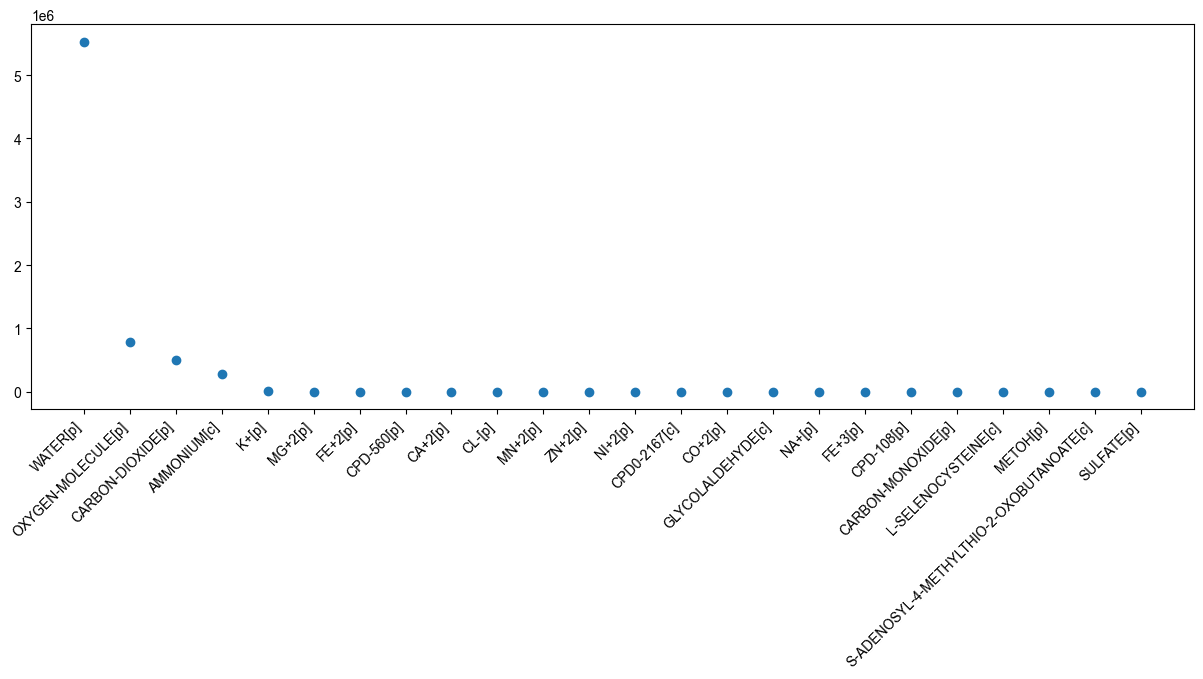

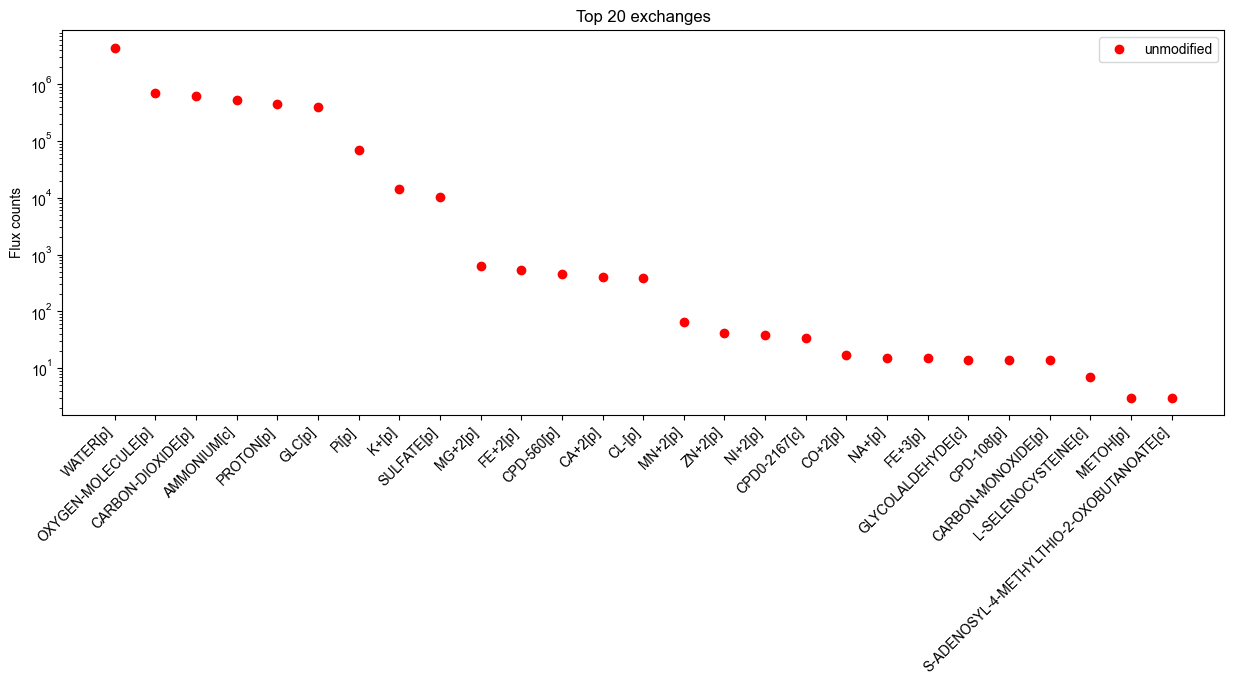

In [55]:
%matplotlib inline
# plot exchanges for basal unchanged model and new model
cur_exchanges = pd.Series(test_exchanges, index=test_metabolites).abs().sort_values(ascending=False)
sim_exchanges = pd.DataFrame(fba_basal["estimated_exchange_dmdt"]).loc[24, :].abs().sort_values(ascending=False)
cur_nonzero = len(cur_exchanges[cur_exchanges > 0])
sim_nonzero = len(sim_exchanges[sim_exchanges > 0])

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(cur_exchanges.head(cur_nonzero).index, cur_exchanges.head(cur_nonzero), 'o', label = 'modified')
plt.xticks(rotation=45, ha= 'right')
plt.figure(figsize=(15, 5))
plt.plot(sim_exchanges.head(sim_nonzero).index, sim_exchanges.head(sim_nonzero), 'ro', label = 'unmodified')

# shorten all xtick names to 10 characters
# plt.xticks([i for i in range(nonzero)], [i[:20] for i in cur_exchanges.index[:nonzero]], rotation=45, ha= 'right')
plt.xticks(rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 20 exchanges')
plt.legend()
plt.show()